## 데이터 전처리

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


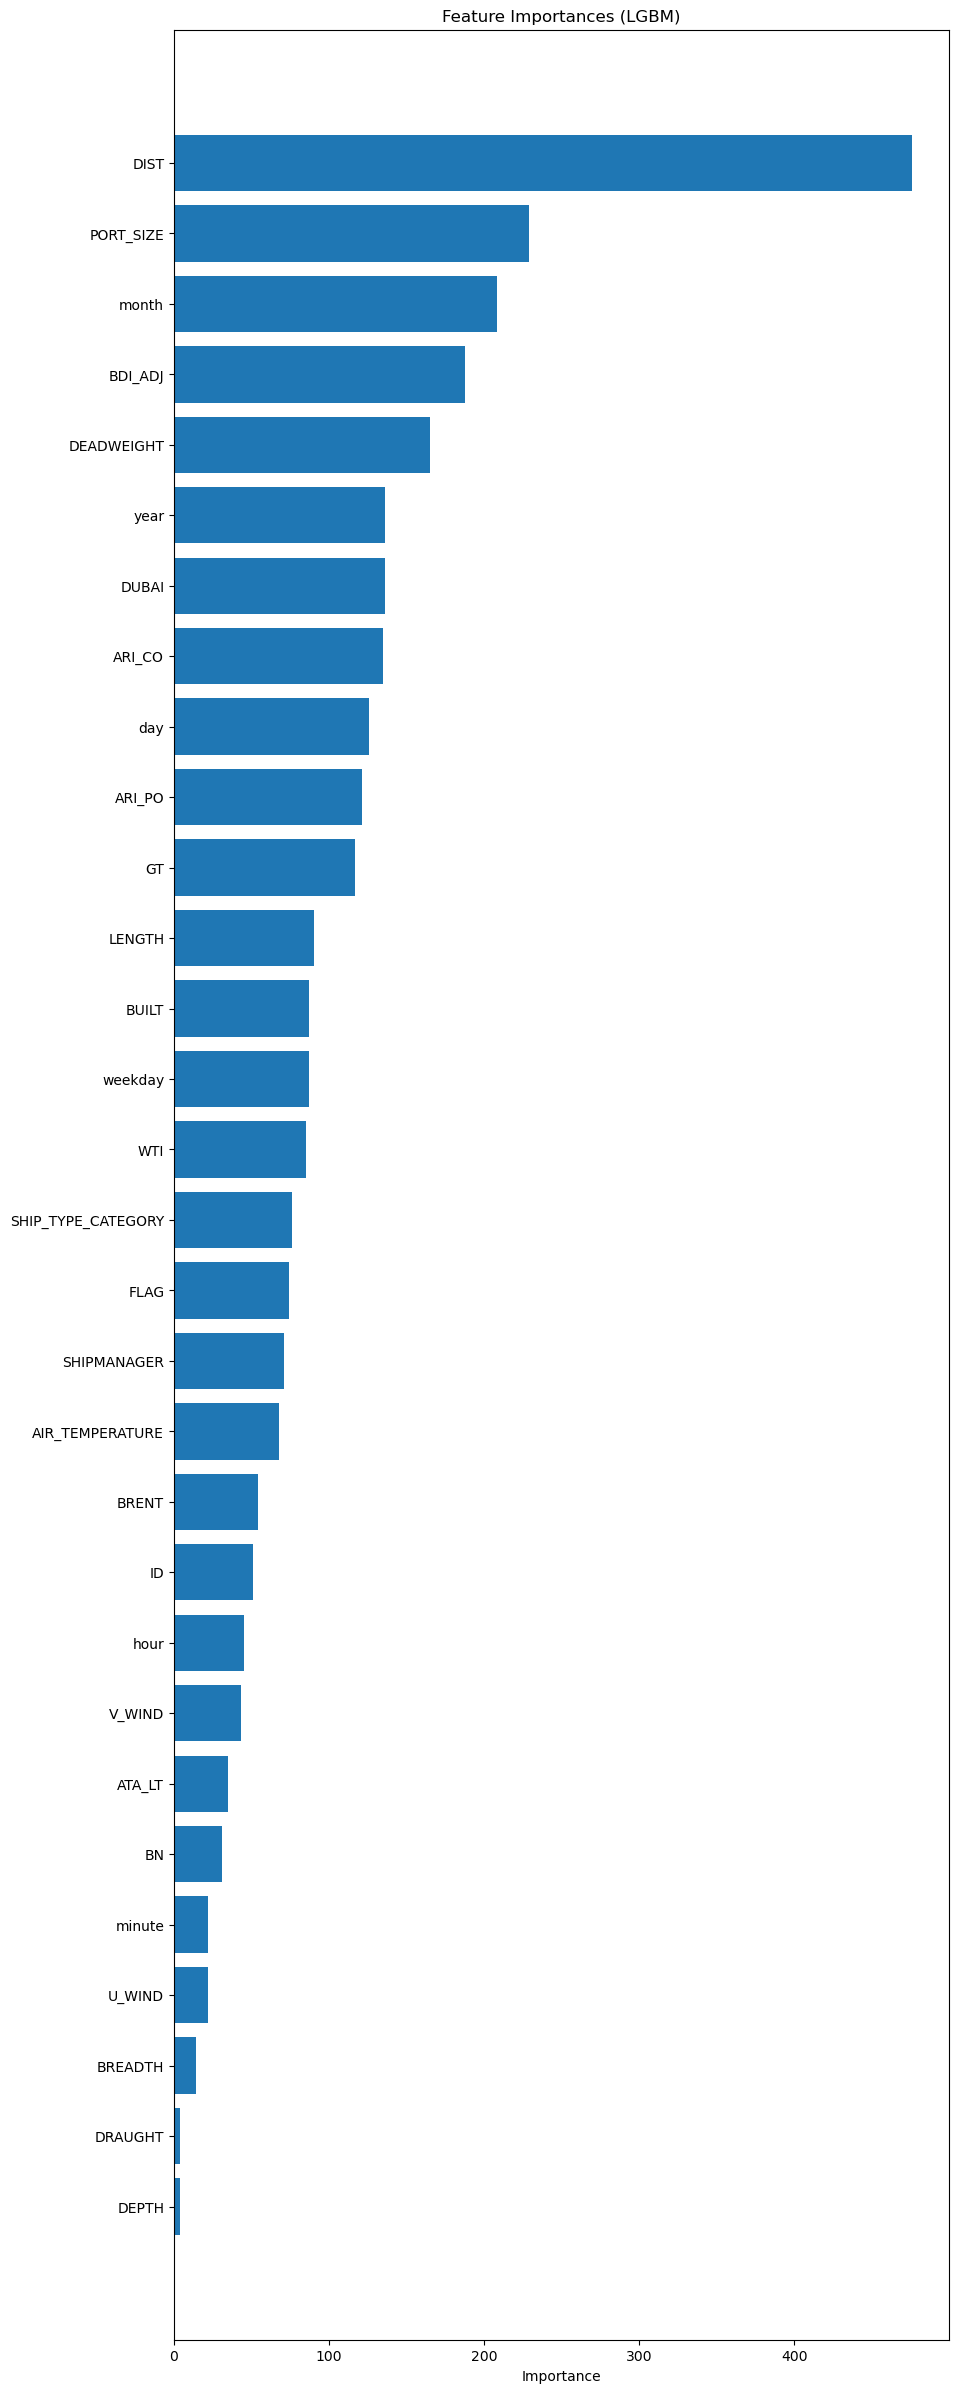

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('data/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('data/test.csv').drop(columns=['SAMPLE_ID'])






# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])
# datetime을 여러 파생 변수로 변환
## datetime을 학습하기 위해 년 ~ 분까지 데이터를 나눔.
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)








def train_and_evaluate(model, model_name, X_train, y_train):
	print(f'Model Tune for {model_name}.')
	model.fit(X_train, y_train)

	feature_importances = model.feature_importances_
	sorted_idx = feature_importances.argsort()

	plt.figure(figsize=(10, len(X_train.columns)))
	plt.title(f"Feature Importances ({model_name})")
	plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
	plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
	plt.xlabel('Importance')
	plt.show()

	return model, feature_importances


X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [9]:
## 영향이 적은 데이터 버리기

threshold = 90 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features) # column을 날리는 거라 데이터 개수에 영향 x

X_test_reduced = test.drop(columns=low_importance_features)

print(X_train_reduced.shape)

(367441, 12)


In [4]:
## 모델들 불러오기

# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from sklearn.linear_model import ElasticNet
# from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor, Pool
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet


In [11]:
## KFold 설정

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

In [12]:
# xgbr
xgb_pred_list = []
xgb_val_list = []
n = 0
for tr_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    n += 1
    print(f'{n} FOLD Training.....')
    X_t, X_val = X_train_reduced.iloc[tr_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[tr_idx], y_train[val_idx]

    #############
    xgb = XGBRegressor(
        random_state = 42,
        learning_rate=0.3,
        n_estimators=50000,
        # tree_method='gpu_hist',
        # gpu_id=0,
        # booster='dart',
        max_depth=6,
        )
    xgb.fit(X_t, y_t)

    val_pred = xgb.predict(X_val)
    val_nmae = mean_absolute_error(y_val, val_pred)
    xgb_val_list.append(val_nmae)
    print(f'{n} FOLD NMAE = {val_nmae}')

    # test 데이터셋에 대한 예측 수행 후 저장
    xgb_pred = xgb.predict(X_test_reduced)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)
    xgb_pred_list.append(xgb_pred)

print(f'10FOLD Mean of NMAE = {np.mean(xgb_val_list)}')

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

1 FOLD Training.....
1 FOLD NMAE = 18.87661052706565


Processing folds:  20%|██        | 1/5 [07:13<28:53, 433.45s/it]

2 FOLD Training.....


Processing folds:  20%|██        | 1/5 [08:06<32:25, 486.29s/it]


KeyboardInterrupt: 

In [6]:
import joblib

# catboost
cb_pred_list = []
cb_val_list = []
n = 0
for tr_idx, val_idx in tqdm(kf.split(X_train_reduced), total=10, desc="Processing folds"):
    n += 1

    X_t, X_val = X_train_reduced.iloc[tr_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[tr_idx], y_train[val_idx]

    #############
    cb = CatBoostRegressor(
        depth=13,
        random_state=42,
        learning_rate=0.1,
        n_estimators=20000,
        loss_function='RMSE',
        task_type="CPU",
        bootstrap_type="Bayesian",
    )
    cb.fit(X_t, y_t)

    val_pred = cb.predict(X_val)
    val_nmae = mean_absolute_error(y_val, val_pred)
    cb_val_list.append(val_nmae)
    print(f'{n} FOLD NMAE = {val_nmae}')

    ## 모델 저장 ##
    joblib.dump(cb, f"models/cat_fold---{n}.pkl")

    # test 데이터셋에 대한 예측 수행 후 저장
    cb_pred = cb.predict(X_test_reduced)
    cb_pred = np.where(cb_pred < 0, 0, cb_pred)
    cb_pred_list.append(cb_pred)

print(f'10FOLD Mean of NMAE = {np.mean(cb_val_list)}')

Processing folds:   0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 167.6534071	total: 405ms	remaining: 2h 14m 54s
1:	learn: 164.8678364	total: 577ms	remaining: 1h 36m 9s
2:	learn: 162.6038336	total: 791ms	remaining: 1h 27m 49s
3:	learn: 160.7171175	total: 1.04s	remaining: 1h 26m 20s
4:	learn: 158.9819117	total: 1.28s	remaining: 1h 25m 8s
5:	learn: 157.6182970	total: 1.45s	remaining: 1h 20m 21s
6:	learn: 155.9870531	total: 1.62s	remaining: 1h 17m 2s
7:	learn: 154.9398989	total: 1.78s	remaining: 1h 14m 16s
8:	learn: 153.9623062	total: 1.99s	remaining: 1h 13m 41s
9:	learn: 152.9511055	total: 2.2s	remaining: 1h 13m 23s
10:	learn: 152.2772676	total: 2.39s	remaining: 1h 12m 30s
11:	learn: 151.3264673	total: 2.55s	remaining: 1h 10m 55s
12:	learn: 150.7950044	total: 2.71s	remaining: 1h 9m 22s
13:	learn: 150.2612630	total: 2.88s	remaining: 1h 8m 32s
14:	learn: 149.6508050	total: 3.05s	remaining: 1h 7m 40s
15:	learn: 149.2106523	total: 3.22s	remaining: 1h 6m 57s
16:	learn: 148.6108624	total: 3.37s	remaining: 1h 6m
17:	learn: 148.2213115	total: 3.55s	r

Processing folds:  10%|█         | 1/10 [52:09<7:49:29, 3129.94s/it]

0:	learn: 167.4985219	total: 184ms	remaining: 1h 1m 27s
1:	learn: 164.7841001	total: 366ms	remaining: 1h 1m
2:	learn: 162.5891002	total: 531ms	remaining: 59m 2s
3:	learn: 160.7493694	total: 615ms	remaining: 51m 14s
4:	learn: 159.1278112	total: 769ms	remaining: 51m 15s
5:	learn: 157.7701565	total: 907ms	remaining: 50m 22s
6:	learn: 156.5209425	total: 1.05s	remaining: 49m 50s
7:	learn: 155.5504216	total: 1.18s	remaining: 49m 7s
8:	learn: 154.5824074	total: 1.32s	remaining: 49m
9:	learn: 153.5545763	total: 1.47s	remaining: 48m 56s
10:	learn: 152.2928070	total: 1.61s	remaining: 48m 51s
11:	learn: 151.5117074	total: 1.76s	remaining: 48m 49s
12:	learn: 150.9142254	total: 1.91s	remaining: 48m 52s
13:	learn: 150.4435400	total: 2.05s	remaining: 48m 45s
14:	learn: 149.7519488	total: 2.19s	remaining: 48m 44s
15:	learn: 149.3550229	total: 2.34s	remaining: 48m 42s
16:	learn: 148.9212034	total: 2.48s	remaining: 48m 40s
17:	learn: 148.3412211	total: 2.63s	remaining: 48m 37s
18:	learn: 148.0545740	tot

Processing folds:  10%|█         | 1/10 [58:29<8:46:27, 3509.77s/it]


KeyboardInterrupt: 

In [13]:
## 딥러닝 ANN 테스트
import tensorflow as tf
tf.__version__

'2.11.0'

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_reduced, y_train, test_size = 0.2, random_state = 0)


In [30]:
ann = tf.keras.models.Sequential()

In [54]:
ann.add(tf.keras.layers.Dense(units=124, activation='relu'))
ann.add(tf.keras.layers.Dense(units=124, activation='relu'))
ann.add(tf.keras.layers.Dense(units=60, activation='relu'))
ann.add(tf.keras.layers.Dense(units=20, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1))

In [55]:
ann.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae', metrics=['MAE'])

In [56]:
ann.fit(X_train, y_train, batch_size = 32, epochs = 10)

Epoch 1/10
9186/9186 [==============================] - 34s 3ms/step - loss: 61.2718 - MAE: 61.2718
Epoch 2/10
4721/9186 [==============>...............] - ETA: 15s - loss: 60.6908 - MAE: 60.6908

KeyboardInterrupt: 

In [47]:
from sklearn.metrics import mean_absolute_error
y_pred = ann.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

2297/2297 [==============================] - 2s 981us/step
60.72121897950177
